# Solve Poisson's Equation on a Ring based on PINNS

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/physics_driven/mindspore_poisson_ring.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/physics_driven/mindspore_poisson_ring.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/poisson_ring.ipynb)

This notebook requires MindSpore version >= 2.0.0 to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

Poisson's equation is an elliptic partial differential equation of broad utility in theoretical physics. For example, the solution to Poisson's equation is the potential field caused by a given electric charge or mass density distribution; with the potential field known, one can then calculate electrostatic or gravitational (force) field.

## Problem Description

We start from a 2-D homogeneous Poisson equation,

$$
f + \Delta u = 0
$$

where `u` is the primary variable, `f` is the source term, and $\Delta$ denotes the Laplacian operator.

We consider the source term `f` is given ($f=1.0$), then the form of Poisson' equation is as follows:

$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + 1.0 = 0,
$$

In this case, the Dirichlet boundary condition and the Neumann boundary condition are used. The format is as follows:

Dirichlet boundary condition on the boundary of outside circle:

$$
u = 0
$$

Neumann boundary condition on the boundary of inside circle：

$$
du/dn = 0
$$

In this case, the PINNs method is used to learn the mapping $(x, y) \mapsto u$. So that the solution of Poisson' equation is realized.

## Technology Path

MindFlow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. Problem Modeling.
5. Model Training.
6. Model Evaluation and Visualization.

In [1]:
import time
import numpy as np
import sympy

from mindspore import nn, ops, Tensor, set_context, set_seed, jit
from mindspore import dtype as mstype
import mindspore as ms


The following `src` pacakage can be downloaded in [applications/physics_driven/poisson_ring/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/poisson_ring/src).

In [2]:
from mindflow.pde import Poisson, sympy_to_mindspore
from mindflow.cell import MultiScaleFCCell
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, calculate_l2_error, visual_result


set_seed(123456)
set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=5)


Load configutationos from `poisson2d_cfg.yaml` , parameters can be modified in [configuration file](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/physics_driven/poisson_ring/poisson2d_cfg.yaml).

In [3]:
# load configurations
config = load_yaml_config('poisson2d_cfg.yaml')

## Training Dataset Construction

In this case, random sampling is performed according to the solution domain, initial condition and boundary value condition to generate training data sets. The specific settings are as follows:

In [4]:
# create training dataset
dataset = create_training_dataset(config)
train_dataset = dataset.batch(batch_size=config["train_batch_size"])

# create  test dataset
inputs, label = create_test_dataset(config)

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [5]:
# define models and optimizers
model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act=config["model"]["activation"],
                         num_scales=1)

## Optimizer

In [6]:
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])


## Problem Modeling

The following `Poission` includes the governing equations, Dirichlet boundary conditions, Norman boundary conditions, etc. The `sympy` is used for delineating partial differential equations in symbolic forms and computing all equations' loss.

In [7]:
class Poisson2D(Poisson):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        super(Poisson2D, self).__init__(model, loss_fn=loss_fn)
        self.bc_outer_nodes = sympy_to_mindspore(self.bc_outer(), self.in_vars, self.out_vars)
        self.bc_inner_nodes = sympy_to_mindspore(self.bc_inner(), self.in_vars, self.out_vars)

    def bc_outer(self):
        bc_outer_eq = self.u
        equations = {"bc_outer": bc_outer_eq}
        return equations

    def bc_inner(self):
        bc_inner_eq = sympy.Derivative(self.u, self.normal) - 0.5
        equations = {"bc_inner": bc_inner_eq}
        return equations

    def get_loss(self, pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_inner_res = self.parse_node(self.bc_inner_nodes, inputs=bc_inner_data, norm=bc_inner_normal)
        bc_inner_loss = self.loss_fn(bc_inner_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_outer_res = self.parse_node(self.bc_outer_nodes, inputs=bc_outer_data)
        bc_outer_loss = self.loss_fn(bc_outer_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + bc_inner_loss + bc_outer_loss


## Model Training

With MindSpore version >= 2.0.0, we can use the functional programming for training neural networks.

In [8]:
def train():
    problem = Poisson2D(model)

    def forward_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        loss = problem.get_loss(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        loss, grads = grad_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    steps = config["train_steps"]
    sink_process = ms.data_sink(train_step, train_dataset, sink_size=1)
    model.set_train()
    for step in range(steps):
        local_time_beg = time.time()
        cur_loss = sink_process()
        if step % 100 == 0:
            print(f"loss: {cur_loss.asnumpy():>7f}")
            print("step: {}, time elapsed: {}ms".format(step, (time.time() - local_time_beg) * 1000))
            calculate_l2_error(model, inputs, label, config["train_batch_size"])
    visual_result(model, inputs, label, step+1)


In [9]:
time_beg = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - time_beg))

poission: Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0
    Item numbers of current derivative formula nodes: 3
bc: u(x, y)
    Item numbers of current derivative formula nodes: 1
bc_r: Derivative(u(x, y), n) - 0.5
    Item numbers of current derivative formula nodes: 2


loss: 1.257777
step: 0, time elapsed: 7348.472833633423ms
    predict total time: 151.28588676452637 ms
    l2_error:  1.1512688311539545
loss: 0.492176
step: 100, time elapsed: 246.30475044250488ms
    predict total time: 1.9807815551757812 ms
    l2_error:  0.7008664085681209
loss: 0.006177
step: 200, time elapsed: 288.0725860595703ms
    predict total time: 2.8748512268066406 ms
    l2_error:  0.035529497589628596
loss: 0.003083
step: 300, time elapsed: 276.9205570220947ms
    predict total time: 4.449129104614258 ms
    l2_error:  0.034347416303136924
loss: 0.002125
step: 400, time elapsed: 241.45269393920898ms
    predict total time: 1.9965171813964844 ms
    l2_error:  0.024273206318798948
...
loss: 0.000126
step: 4500, time elapsed: 245.61786651611328ms
    predict total time: 8.903980255126953 ms
    l2_error:  0.009561532889489787
loss: 0.000145
step: 4600, time elapsed: 322.16882705688477ms
    predict total time: 7.802009582519531 ms
    l2_error:  0.015489169733942706
loss:

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

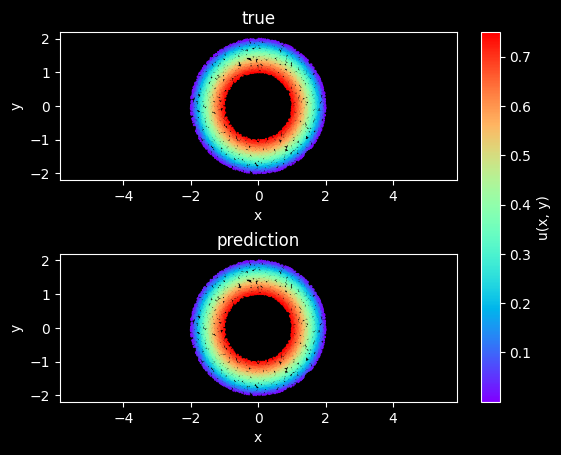

In [10]:
# visualization
steps = config["train_steps"]
visual_result(model, inputs, label, steps+1)